### 1. Prepapacion de los datos


In [ ]:
import pandas as pd
import numpy as np

# Cargar el JSON
df = pd.read_json("TelecomX_Data.json")

# ---- 1. Valores ausentes ----
print("Valores nulos por columna:\n", df.isnull().sum())
print("\nValores vacíos en 'Churn':", (df['Churn'] == "").sum())

# ---- 2. Duplicados ----
print("\nDuplicados en customerID:", df['customerID'].duplicated().sum())

# ---- 3. Tipos de datos ----
print("\nTipos de datos:\n", df.dtypes)

# Extract features from nested dictionaries
df['TotalCharges'] = pd.to_numeric(df['account'].apply(lambda x: x['Charges']['Total']), errors='coerce')
df['Gender'] = df['customer'].apply(lambda x: x['gender'])
df['SeniorCitizen'] = df['customer'].apply(lambda x: x['SeniorCitizen'])
df['Partner'] = df['customer'].apply(lambda x: x['Partner'])
df['Dependents'] = df['customer'].apply(lambda x: x['Dependents'])
df['Tenure'] = df['customer'].apply(lambda x: x['tenure'])
df['PhoneService'] = df['phone'].apply(lambda x: x['PhoneService'])
df['MultipleLines'] = df['phone'].apply(lambda x: x['MultipleLines'])
df['InternetService'] = df['internet'].apply(lambda x: x['InternetService'])
df['OnlineSecurity'] = df['internet'].apply(lambda x: x['OnlineSecurity'])
df['OnlineBackup'] = df['internet'].apply(lambda x: x['OnlineBackup'])
df['DeviceProtection'] = df['internet'].apply(lambda x: x['DeviceProtection'])
df['TechSupport'] = df['internet'].apply(lambda x: x['TechSupport'])
df['StreamingTV'] = df['internet'].apply(lambda x: x['StreamingTV'])
df['StreamingMovies'] = df['internet'].apply(lambda x: x['StreamingMovies'])
df['Contract'] = df['account'].apply(lambda x: x['Contract'])
df['PaperlessBilling'] = df['account'].apply(lambda x: x['PaperlessBilling'])
df['PaymentMethod'] = df['account'].apply(lambda x: x['PaymentMethod'])
df['MonthlyCharges'] = df['account'].apply(lambda x: x['Charges']['Monthly'])


# Drop original nested columns
df = df.drop(columns=['customer', 'phone', 'internet', 'account', 'customerID'])


# ---- 4. Categorías únicas ----
print("\nValores únicos en 'Churn':", df['Churn'].unique())
print("Valores únicos en 'MultipleLines':", pd.unique(df['MultipleLines']))
print("Valores únicos en 'InternetService':", pd.unique(df['InternetService']))

Valores nulos por columna:
 customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64

Valores vacíos en 'Churn': 224

Duplicados en customerID: 0

Tipos de datos:
 customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object

Valores únicos en 'Churn': ['No' 'Yes' '']
Valores únicos en 'MultipleLines': ['No' 'Yes' 'No phone service']
Valores únicos en 'InternetService': ['DSL' 'Fiber optic' 'No']


In [ ]:
# Eliminar columnas que no aportan valor (ej. identificadores únicos)
cols_to_drop = ["customerID"]  # puedes agregar más si detectas otras irrelevantes
df = df.drop(columns=cols_to_drop, errors="ignore")

# Verificar que ya no existe
print(df.columns)

Index(['Churn', 'customer', 'phone', 'internet', 'account', 'TotalCharges'], dtype='object')


In [ ]:
# One-hot encoding for categorical variables
categorical_cols = df.select_dtypes(include=["object", "category"]).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Verify result
print(df_encoded.head())

   TotalCharges  SeniorCitizen  Tenure  MonthlyCharges  Churn_No  Churn_Yes  \
0        593.30              0       9            65.6      True      False   
1        542.40              0       9            59.9      True      False   
2        280.85              0       4            73.9     False       True   
3       1237.85              1      13            98.0     False       True   
4        267.40              1       3            83.9     False       True   

   Gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0        False         True            True              True  ...   
1         True        False           False              True  ...   
2         True        False           False              True  ...   
3         True         True           False              True  ...   
4        False         True           False              True  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False             Tr

In [ ]:
# Calcular proporción de clientes que cancelaron vs activos
proporcion = df["Churn"].value_counts(normalize=True)

print("Distribución de Churn (conteo):")
print(df["Churn"].value_counts())
print("\nProporción de Churn:")
print(proporcion)

Distribución de Churn (conteo):
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Proporción de Churn:
Churn
No     0.711986
Yes    0.257190
       0.030824
Name: proportion, dtype: float64


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['Churn_No', 'Churn_Yes'], axis=1)
y = df_encoded['Churn_Yes']

X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", y_train_smote.value_counts())

Class distribution before SMOTE: Churn_Yes
False    4318
True     1495
Name: count, dtype: int64
Class distribution after SMOTE: Churn_Yes
False    4318
True     4318
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Seleccionar solo las columnas numéricas
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Evaluar modelos basados en distancia
# Escalado estándar (media=0, std=1)
scaler_std = StandardScaler()
df_std = df.copy()
df_std[numerical_cols] = scaler_std.fit_transform(df_std[numerical_cols])

# Escalado Min-Max (0-1)
scaler_mm = MinMaxScaler()
df_mm = df.copy()
df_mm[numerical_cols] = scaler_mm.fit_transform(df_mm[numerical_cols])

print("Datos escalados con StandardScaler:")
print(df_std.head())

print("\nDatos escalados con MinMaxScaler:")
print(df_mm.head())

Datos escalados con StandardScaler:
  Churn  TotalCharges
0    No     -0.743818
1    No     -0.766256
2   Yes     -0.881554
3   Yes     -0.459685
4   Yes     -0.887483

Datos escalados con MinMaxScaler:
  Churn  TotalCharges
0    No      0.066294
1    No      0.060420
2   Yes      0.030239
3   Yes      0.140670
4   Yes      0.028687


### 2. Analisis de Correcion

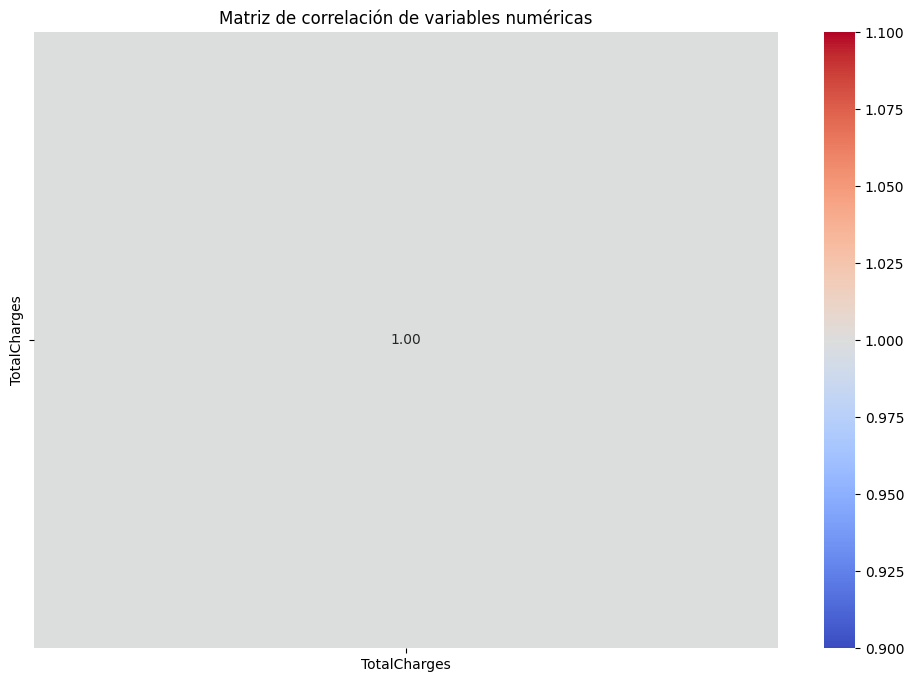

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calcular la matriz de correlación
corr_matrix = df[numerical_cols].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación de variables numéricas")
plt.show()

# Correlación con la variable de cancelación (suponiendo que se llama 'cancelado')
if 'cancelado' in numerical_cols:
    print("\nCorrelación de cada variable con 'cancelado':")
    print(corr_matrix['cancelado'].sort_values(ascending=False))

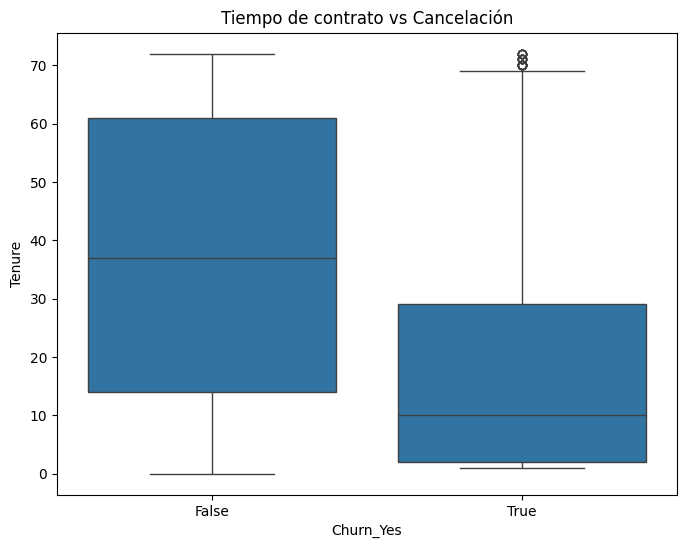

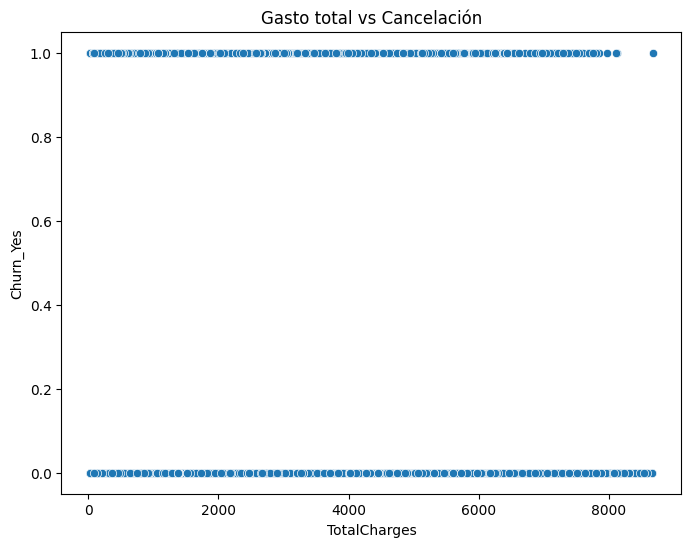

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot: Tiempo de contrato vs Cancelación
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn_Yes', y='Tenure', data=df_encoded)
plt.title('Tiempo de contrato vs Cancelación')
plt.show()

# Scatter plot: Gasto total vs Cancelación
plt.figure(figsize=(8,6))
sns.scatterplot(x='TotalCharges', y='Churn_Yes', data=df_encoded)
plt.title('Gasto total vs Cancelación')
plt.show()

### 3. Modelo Predictivo

In [ ]:
from sklearn.model_selection import train_test_split

print("Shape of X_train_smote:", X_train_smote.shape)
print("Shape of y_train_smote:", y_train_smote.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_smote: (8636, 1)
Shape of y_train_smote: (8636,)
Shape of X_test: (1454, 1)
Shape of y_test: (1454,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Modelo 1 ---

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_smote_scaled, y_train_smote)

y_pred_logistic = logistic_model.predict(X_test_scaled)
print("--- Logistic Regression Model ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logistic))
print("\nAccuracy:", accuracy_score(y_test, y_pred_logistic))


# --- Model 2  ---
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_smote, y_train_smote)

y_pred_rf = random_forest_model.predict(X_test)
print("\n--- Random Forest Model ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nAccuracy:", accuracy_score(y_test, y_pred_rf))

--- Logistic Regression Model ---
Confusion Matrix:
 [[468 612]
 [ 95 279]]

Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.43      0.57      1080
        True       0.31      0.75      0.44       374

    accuracy                           0.51      1454
   macro avg       0.57      0.59      0.51      1454
weighted avg       0.70      0.51      0.54      1454


Accuracy: 0.5137551581843192

--- Random Forest Model ---
Confusion Matrix:
 [[638 442]
 [203 171]]

Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.59      0.66      1080
        True       0.28      0.46      0.35       374

    accuracy                           0.56      1454
   macro avg       0.52      0.52      0.51      1454
weighted avg       0.64      0.56      0.58      1454


Accuracy: 0.5563961485557084


### 4. Interpretacion y conclusiones

In [ ]:
if 'logistic_model' in locals() and 'X_train_smote_scaled' in locals():
    print("\n--- Logistic Regression Model - Feature Coefficients ---")
    feature_names = X_train_smote.columns

    coefficients = logistic_model.coef_[0]

    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

    coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

    display(coef_df)

else:
    print("Logistic Regression model or scaled training data not found. Please run the previous cells.")


--- Logistic Regression Model - Feature Coefficients ---


,Feature,Coefficient,Abs_Coefficient
0,TotalCharges,-0.48487,0.48487


In [ ]:
if 'random_forest_model' in locals() and 'X_train_smote' in locals():
    print("\n--- Random Forest Model - Feature Importance ---")

    importances = random_forest_model.feature_importances_

    feature_names = X_train_smote.columns

    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    display(feature_importance_df)

else:
    print("Random Forest model or training data not found. Please run the previous cells.")


--- Random Forest Model - Feature Importance ---


,Feature,Importance
0,TotalCharges,1.0


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

# Churn a categorías consistentes
if "Churn" in df.columns:
    df["Churn"] = df["Churn"].replace("", "Unknown")
else:
    raise ValueError("No se encontró la columna 'Churn' en el JSON.")

# Unificar categorías de servicio
def repl_no_phone_service(x):
    return "No" if isinstance(x, str) and x.strip().lower() == "no phone service" else x
def repl_no_internet_service(x):
    return "No" if isinstance(x, str) and x.strip().lower() == "no internet service" else x

if "phone.MultipleLines" in df.columns:
    df["phone.MultipleLines"] = df["phone.MultipleLines"].apply(repl_no_phone_service)

internet_cols = ["internet.InternetService","internet.OnlineSecurity","internet.OnlineBackup",
                 "internet.DeviceProtection","internet.TechSupport","internet.StreamingTV","internet.StreamingMovies"]
for col in internet_cols:
    if col in df.columns:
        df[col] = df[col].apply(repl_no_internet_service)

# SeniorCitizen a flag y texto
if "customer.SeniorCitizen" in df.columns:
    df["SeniorCitizenFlag"] = df["customer.SeniorCitizen"].apply(lambda v: 1 if v==1 else 0)
    df["customer.SeniorCitizen"] = df["customer.SeniorCitizen"].apply(lambda v: "Yes" if v==1 else "No")

# Cargos a numérico
if "account.Charges.Monthly" in df.columns:
    df["MonthlyCharges"] = pd.to_numeric(df["account.Charges.Monthly"], errors="coerce")
if "account.Charges.Total" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["account.Charges.Total"], errors="coerce")

# Cargos diarios
if "MonthlyCharges" in df.columns:
    df["Cuentas_Diarias"] = df["MonthlyCharges"] / 30.0

# Traducciones/renombres (para legibilidad; opcional)
df = df.rename(columns={
    "customer.gender": "Genero",
    "customer.tenure": "Meses_Contrato",
    "account.Contract": "Tipo_Contrato",
    "account.PaymentMethod": "Metodo_Pago",
    "MonthlyCharges": "Cargos_Mensuales",
    "TotalCharges": "Cargos_Totales",
    "phone.MultipleLines": "MultipleLines",
    "account.PaperlessBilling": "PaperlessBilling"
})

# Eliminar columnas no útiles (identificadores, etc.)
drop_cols = ["customerID"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Quitar filas con Churn "Unknown" (no sirven como etiqueta)
df = df[df["Churn"].isin(["Yes","No"])].copy()

# Crear objetivo binario
df["ChurnFlag"] = df["Churn"].map({"No":0, "Yes":1})

# Eliminar columnas no hashables (listas/dicts) que pueden quedar de la normalización
bad_cols = []
for col in df.columns:
    # si hay dict o list en alguna celda, descartar columna
    if df[col].apply(lambda x: isinstance(x, (dict, list))).any():
        bad_cols.append(col)
if bad_cols:
    df = df.drop(columns=bad_cols)

# ---------- 3) SELECCIÓN DE VARIABLES ----------
y = df["ChurnFlag"].astype(int)
X = df.drop(columns=["Churn","ChurnFlag"])

# Columnas por tipo
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

# ---------- 4) TRAIN/TEST SPLIT ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ---------- 5) PIPELINES DE MODELOS ----------
# Preprocesamiento
preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# Modelos
pipe_lr = Pipeline(steps=[
    ("prep", preprocess_lr),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])

pipe_rf = Pipeline(steps=[
    ("prep", preprocess_tree),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, random_state=42, class_weight="balanced_subsample"
    ))
])

pipe_gb = Pipeline(steps=[
    ("prep", preprocess_tree),
    ("clf", GradientBoostingClassifier(random_state=42))
])

modelos = {
    "LogisticRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "GradientBoosting": pipe_gb
}

# ---------- 6) ENTRENAMIENTO Y EVALUACIÓN ----------
resultados = {}
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist(),
        "classification_report": classification_report(y_test, y_pred, digits=4)
    }
    resultados[nombre] = {"metrics": metrics}

# ---------- 7) IMPORTANCIA DE VARIABLES ----------
def feature_names_from_ct(column_transformer):
    names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            trans_names = trans.get_feature_names_out(cols)
        else:
            trans_names = cols
        names.extend(list(trans_names))
    return names

def top_importances(modelo, nombre_modelo, k=15):
    # Obtener matriz X_test transformada y nombres de features
    prep = modelo.named_steps["prep"]
    X_test_t = prep.transform(X_test)
    feat_names = feature_names_from_ct(prep)

    # Importancia por modelo
    importancias = None
    if nombre_modelo == "LogisticRegression":
        clf = modelo.named_steps["clf"]
        coefs = np.ravel(clf.coef_)
        importancias = np.abs(coefs)
    elif nombre_modelo in ("RandomForest","GradientBoosting"):
        clf = modelo.named_steps["clf"]
        importancias = clf.feature_importances_

    # Permutation importance (complemento, más costoso)
    try:
        perm = permutation_importance(
            modelo, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )
        perm_scores = perm.importances_mean
    except Exception:
        perm_scores = np.zeros(len(feat_names))

    # Combinar (promedio normalizado de ambas)
    base_imp = importancias if importancias is not None else np.zeros(len(feat_names))
    base_imp = (base_imp - base_imp.min()) / (base_imp.ptp() + 1e-9)
    perm_norm = (perm_scores - np.nanmin(perm_scores)) / (np.nanptp(perm_scores) + 1e-9)
    combo = 0.6*base_imp + 0.4*perm_norm

    imp_df = pd.DataFrame({
        "feature": feat_names,
        "model_importance": base_imp,
        "perm_importance": perm_norm,
        "combined_importance": combo
    }).sort_values("combined_importance", ascending=False)

    return imp_df.head(k)

tops = {}
for nombre, modelo in modelos.items():
    try:
        tops[nombre] = top_importances(modelo, nombre, k=20)
    except Exception:
        tops[nombre] = pd.DataFrame(columns=["feature","combined_importance"])

# ---------- 8) CONSOLIDACIÓN DE FACTORES CLAVE ----------
# Agregar importancias promedio entre modelos (cuando existan)
all_feats = pd.concat([dfi[["feature","combined_importance"]] for dfi in tops.values() if not dfi.empty], ignore_index=True)
if not all_feats.empty:
    resumen_imp = (all_feats
                   .groupby("feature", as_index=False)["combined_importance"]
                   .mean()
                   .sort_values("combined_importance", ascending=False))
    factores_top = resumen_imp.head(20)
else:
    factores_top = pd.DataFrame(columns=["feature","combined_importance"])

# ---------- 9) GENERACIÓN DE INFORME ----------
def format_metrics(m):
    return (f"Accuracy: {m['accuracy']:.4f} | Precision: {m['precision']:.4f} | "
            f"Recall: {m['recall']:.4f} | F1: {m['f1']:.4f} | ROC-AUC: {m['roc_auc']:.4f}")

dist = y.value_counts(normalize=True)
imbalance_note = f"Distribución de clases -> No: {dist.get(0,0):.3f}, Sí: {dist.get(1,0):.3f}"

lineas = []
lineas.append("# Informe de Factores de Cancelación (Telecom X)\n")
lineas.append("## Resumen de Modelos y Métricas\n")
lineas.append(imbalance_note + "\n")
for nombre, info in resultados.items():
    lineas.append(f"### {nombre}")
    lineas.append(format_metrics(info["metrics"]))
    lineas.append("Matriz de confusión ([[TN, FP],[FN, TP]]): " + str(info["metrics"]["confusion_matrix"]))
    lineas.append("Reporte de clasificación:\n" + info["metrics"]["classification_report"])

lineas.append("\n## Principales Factores Asociados a la Cancelación")
if not factores_top.empty:
    for i, row in factores_top.head(15).iterrows():
        lineas.append(f"- {row['feature']}: importancia combinada {row['combined_importance']:.3f}")
else:
    lineas.append("- No fue posible calcular importancias de forma confiable con los datos disponibles.")

# Recomendaciones basadas en features detectados (heurísticas simples)
recs = []
feat_text = " ".join(factores_top["feature"].astype(str).tolist()).lower()
if "tipo_contrato" in feat_text or "contract" in feat_text:
    recs.append("• Incentivos de permanencia y descuentos escalonados para contratos mensuales.")
if "metodo_pago" in feat_text or "payment" in feat_text or "electronic check" in feat_text:
    recs.append("• Reducir fricción en el cobro (recordatorios, medios automáticos) y promover métodos confiables.")
if "cargos_mensuales" in feat_text or "cargos_totales" in feat_text or "charges" in feat_text:
    recs.append("• Monitoreo de incrementos súbitos en cargos con ofertas proactivas y soporte.")
if "onlineSecurity".lower() in feat_text or "techsupport".lower() in feat_text:
    recs.append("• Bundles de valor (seguridad/soporte) para segmentos de alto riesgo.")
if "meses_contrato" in feat_text or "tenure" in feat_text:
    recs.append("• Programas de lealtad por antigüedad y ofertas en puntos críticos del ciclo de vida.")
if "multiplelines".lower() in feat_text or "internet" in feat_text:
    recs.append("• Paquetes combinados (líneas + internet) con precio preferente para subir el costo de oportunidad.")

if not recs:
    recs.append("• Implementar campañas de retención focalizadas en las variables de mayor importancia detectadas por los modelos.")

lineas.append("\n## Recomendaciones de Retención")
lineas.extend(recs)

# Guardar archivo
out_path = Path("Informe_Modelos_TelecomX.txt")
with open(out_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lineas))

print("\n".join(lineas))
print(f"\nArchivo generado: {out_path.resolve()}")